# Example use of the Sonic module Linckii.jl

In [1]:
import Pkg                      # package manager
Pkg.activate("..")              # Project.toml
Pkg.instantiate()               # https://julialang.github.io/Pkg.jl/v1.0/index.html

Activating environment at `~/Documents/Calendar/Work/Noda/Code/Sonic.jl/Project.toml`


In [2]:
import Dates, JuliaDB, Plots, Random

In [3]:
include("../src/Linckii.jl")
include("../src/LinckiiSecrets.jl")

Main.LinckiiSecrets

Get access token,

In [4]:
access = Linckii.get_access(LinckiiSecrets.keab)

(url = "https://canary.noda.se/~keab", key = "e86d93131e6bc12ae701d036e696cf8b")

GET "https://canary.noda.se/$site_name/api/v1/node"

In [ ]:
@time nodes = Linckii.get_nodes(access)

GET "https://canary.noda.se/$site_name/api/v1/device"

In [ ]:
@time devices = Linckii.get_devices(access)

GET "https://canary.noda.se/$site_name/api/v1/sensor"

In [ ]:
@time sensors = Linckii.get_sensors(access)

Save site,

In [ ]:
@time Linckii.savesite(access; nodes = nodes, devices = devices, sensors = sensors)

Load site,

In [5]:
@time nodes, devices, sensors = Linckii.loadsite(access, :nodes, :devices, :sensors)

 20.115738 seconds (21.13 M allocations: 1.380 GiB, 1.99% gc time)


(nodes = Table with 279 rows, 8 columns:
Columns:
#  colname           type
─────────────────────────────────
1  node_public       Bool
2  node_name         String
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Any,1}
8  node_description  String, devices = Table with 11 rows, 3 columns:
protocol_id  device_name             device_id
──────────────────────────────────────────────
1            "Kelp-IQHeat"           1
2            "Scout"                 2
1            "Kelp-Basic"            4
5            "Weather-Forecast"      6
6            "Grid-Basic"            7
6            "Grid-Controller"       8
7            "Heat-Load-Forecast"    9
2            "CMa1Xw"                10
2            "EcoGuard Sensor"       11
2            "WEPTech"               12
8            "Flexibility-Forecast"  13, sensors = Table with 175 rows, 5 columns:
Columns:
#  colname             type
───────────────────

Get side 1 substation series,

In [6]:
sensor_names = (
    :meter_effect,
    :meter_primreturntemp,
    :meter_primsupplytemp,
    :meter_volumeflow,
)

(:meter_effect, :meter_primreturntemp, :meter_primsupplytemp, :meter_volumeflow)

In [7]:
signals = JuliaDB.reindex(
    JuliaDB.join(
        Linckii.flatten_nodes(JuliaDB.filter(r -> r.device_id == 4, nodes)),
        JuliaDB.filter(r -> r.sensor_name in sensor_names, sensors);
        lkey=:sensor_id,
        rkey=:sensor_id,
    ),
    (:node_id, :sensor_id),
)

Table with 361 rows, 12 columns:
Columns:
#   colname             type
──────────────────────────────
1   node_id             Int64
2   sensor_id           Int64
3   node_public         Bool
4   node_name           String
5   device_id           Int64
6   node_owner          Bool
7   node_enabled        Bool
8   node_description    String
9   sensor_unit         Any
10  sensor_name         Symbol
11  protocol_id         Int64
12  sensor_description  String

In [8]:
signal_rows = JuliaDB.rows(signals)
length(signal_rows)

361

Save data,

In [9]:
dates = Dates.DateTime(2017, 12) : Dates.Month(1) : Dates.DateTime(2019, 12)

2017-12-01T00:00:00:1 month:2019-12-01T00:00:00

In [13]:
if true
    signal_rows = [signal_rows[Random.rand(1 : end)]]
end
@time for r in signal_rows
    filepath = "$(Linckii.datapath(access, r.node_id, r.sensor_name)).db"
    redosave = ~isfile(filepath)
    if redosave
        try
            Linckii.savedata(access, r.node_id, r.sensor_name, dates...)
            println("$(filepath): Done")
        catch e
            println("$(filepath): $(e)")
        end
    end
end

  0.000066 seconds (62 allocations: 3.016 KiB)


Load data,

In [14]:
r = signal_rows[Random.rand(1 : end)]
(r.node_id, r.sensor_name)

(87, :meter_primsupplytemp)

In [15]:
data = Linckii.loaddata(access, r.node_id, r.sensor_name)

Table with 99130 rows, 3 columns:
datetime             timezone  value
────────────────────────────────────
2017-12-01T00:02:03  13:00:00  97.02
2017-12-01T00:12:03  13:00:00  97.54
2017-12-01T00:22:03  13:00:00  98.32
2017-12-01T00:32:02  13:00:00  98.35
2017-12-01T00:42:02  13:00:00  98.51
2017-12-01T01:02:03  13:00:00  97.76
2017-12-01T01:12:03  13:00:00  97.91
2017-12-01T01:22:02  13:00:00  97.42
2017-12-01T01:32:02  13:00:00  97.89
2017-12-01T01:42:03  13:00:00  97.42
2017-12-01T01:52:03  13:00:00  97.69
2017-12-01T02:02:03  13:00:00  97.51
⋮
2019-10-31T22:12:02  13:00:00  90.86
2019-10-31T22:22:02  13:00:00  91.14
2019-10-31T22:32:02  13:00:00  90.75
2019-10-31T22:42:03  13:00:00  90.33
2019-10-31T22:52:03  13:00:00  91.11
2019-10-31T23:02:02  13:00:00  91.56
2019-10-31T23:12:02  13:00:00  91.19
2019-10-31T23:22:02  13:00:00  90.79
2019-10-31T23:32:03  13:00:00  91.41
2019-10-31T23:42:03  13:00:00  92.0
2019-10-31T23:52:02  13:00:00  92.23

Simple plot,

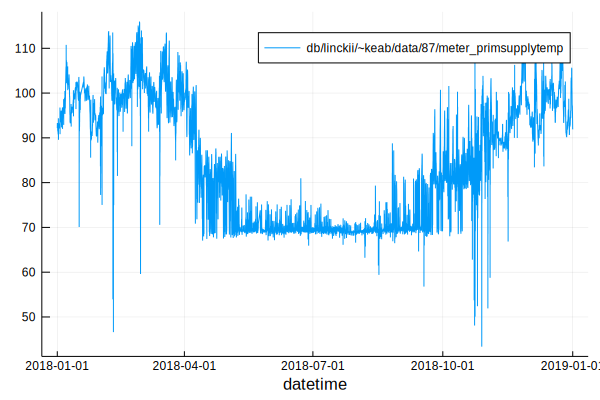

In [16]:
t = JuliaDB.filter(
    r -> r.datetime >= Dates.DateTime(2018) && r.datetime <= Dates.DateTime(2019),
    data,
)
x = JuliaDB.select(t, :datetime)
y = JuliaDB.select(t, :value)
Plots.plot(x, y, xlabel = :datetime, label = Linckii.datapath(access, r.node_id, r.sensor_name))